# Import Libraries

In this step, we import all the necessary libraries for loading, preprocessing, visualizing the dataset, building and training the CNN model, and evaluating its performance. 

- `os` and `random` are used for file operations and controlling randomness.  
- `numpy` handles numerical operations on arrays and image data.  
- `matplotlib.pyplot` is used for visualizing images and dataset distribution.  
- `tensorflow` and `keras` provide the deep learning framework.  
- `ImageDataGenerator` loads images from directories and applies data augmentation.  
- `load_img` loads an image from a file path as a PIL image, useful for visualization or preprocessing.  
- `img_to_array` converts a PIL image into a NumPy array for neural network input.  
- The CNN is built using `Sequential`, `Conv2D`, `MaxPooling2D`, `Dense`, `Dropout`, `BatchNormalization`, and `GlobalAveragePooling2D`.  
- `Adam` is the optimizer for training the model.  
- `classification_report` and `confusion_matrix` from `sklearn` are used for model evaluation.  
- `EfficientNetB0` is imported for transfer learning experiments.

In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import EfficientNetB0
import seaborn as sns

# Load and Preprocess Data
## Dataset Overview

**Dataset Path:** `Human face emotions dataset URL`  
**Classes:** List of human facial emotion categories.

In this step, we explore the dataset by identifying the emotion classes, counting the number of images in each class, and visualizing the data distribution.

### Emotion Classes
```python
Classes: ['Fear', 'Suprise', 'Angry', 'Sad', 'Happy']

Number of Images per Class
	•	Fear: 9,732 images
	•	Suprise: 8,227 images
	•	Angry: 10,148 images
	•	Sad: 12,553 images
	•	Happy: 18,439 images

In [3]:
data_dir = "/kaggle/input/human-face-emotions/Data"
classes = os.listdir(data_dir)
print(f"Classes: {classes}\n")

counts = {}

for cls in classes:
    folder_path = os.path.join(data_dir,cls)
    counts[cls]= len(os.listdir(folder_path))

for cls in classes:
    print(f"{cls}: {counts[cls]} images.")

Classes: ['Fear', 'Suprise', 'Angry', 'Sad', 'Happy']

Fear: 9732 images.
Suprise: 8227 images.
Angry: 10148 images.
Sad: 12553 images.
Happy: 18439 images.


## Visualizing Sample Images from Each Class

To better understand the dataset, we visualize **5 random images from each emotion class**.  
This helps us see variations in facial expressions and verify the quality of the dataset.

### What this code does:
- Iterates through each emotion class directory  
- Selects **5 random images** using `random.sample()`  
- Loads each image with `load_img()` and resizes it to `(128, 128)`  
- Displays all images in a grid where:
  - Each **row** represents one class  
  - Each **column** shows one random sample  
- Removes axis labels for cleaner visualization  
- Uses `plt.tight_layout()` to prevent overlap  

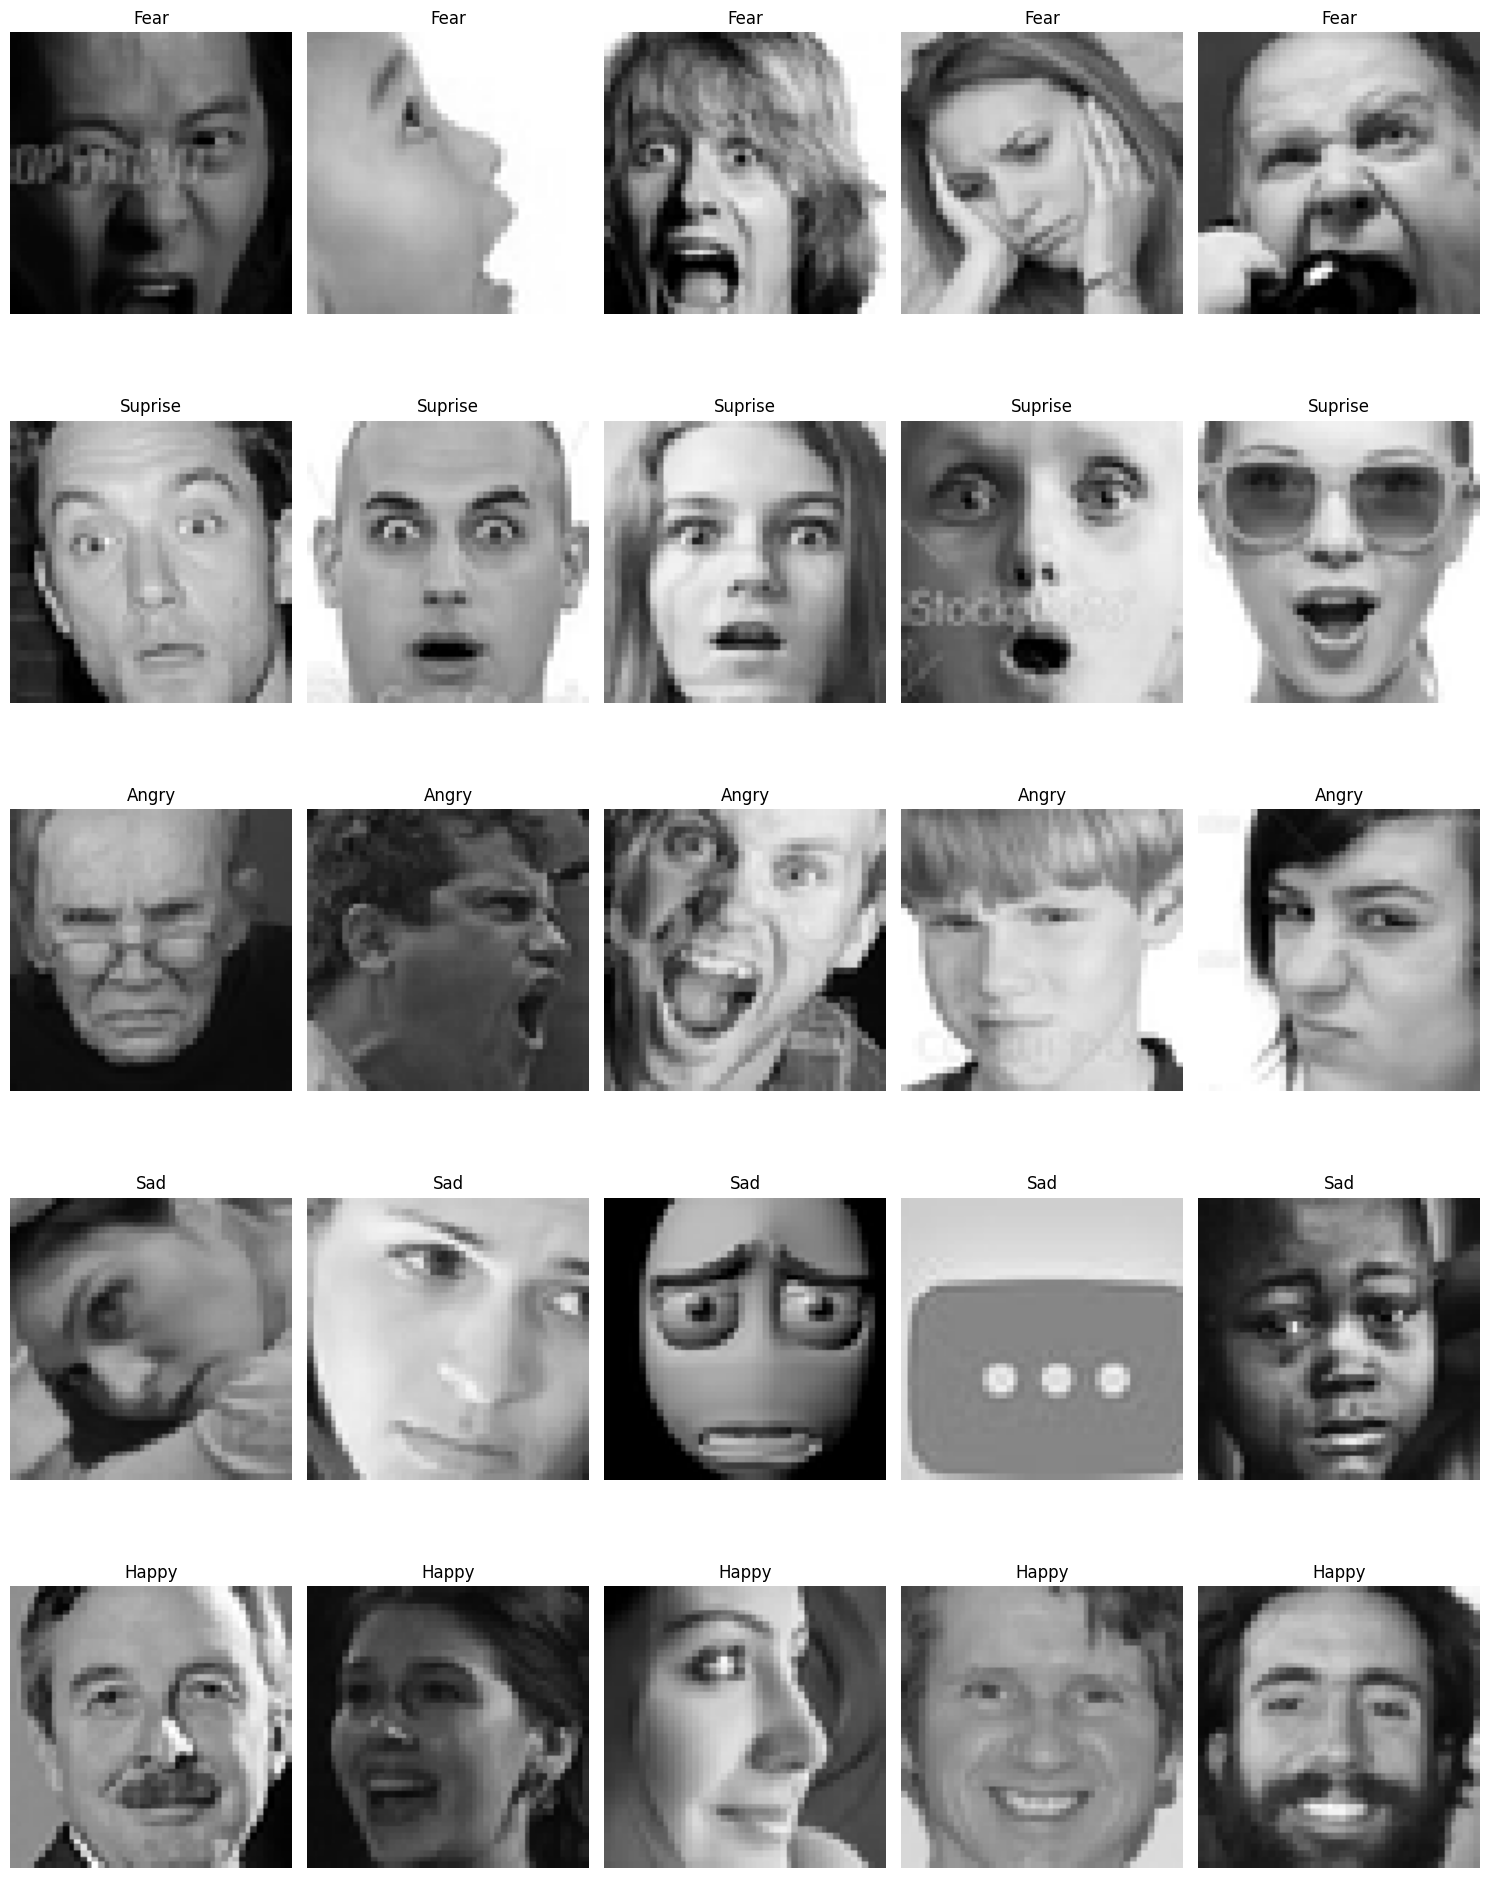

In [4]:
plt.figure(figsize=(15, 20))
index = 1
for cls in classes:
    class_path = os.path.join(data_dir, cls)
    images = os.listdir(class_path)
    samples = random.sample(images, 5)

    for img_name in samples:
        img_path = os.path.join(class_path, img_name)
        img = load_img(img_path, target_size=(128,128))
        plt.subplot(len(classes), 5, index)
        plt.imshow(img)
        plt.axis("off")
        plt.title(cls)
        index +=1
        
plt.tight_layout()
plt.show() 

# Train / Validation Split with ImageDataGenerator

In this step, we split our dataset into training and validation sets using Keras' `ImageDataGenerator`. This also includes data augmentation for the training set to improve model generalization.

**What this code does:**

- **Data Rescaling:** All images are normalized to the range `[0, 1]` by dividing by 255.  
- **Validation Split:** 20% of the data is reserved for validation (`validation_split=0.2`).  
- **Training Generator:**  
  - Loads images from `data_dir` for training.  
  - Resizes images to `(224, 224)`.  
  - Batch size of 32 with one-hot encoded labels (`class_mode='categorical'`).  
  - Only uses the training subset of the data.  
  - Applies data augmentation including rotation, width/height shift, zoom, shear, and horizontal flip.  

- **Validation Generator:**  
  - Same as training, but only uses the validation subset.  
  - No data augmentation, only rescaling.

In [5]:

train_generator = tf.keras.utils.image_dataset_from_directory(
    directory=data_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=64,
    image_size=(224, 224)
)

validation_generator = tf.keras.utils.image_dataset_from_directory(
    directory=data_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=64,
    image_size=(224, 224)
)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomBrightness(0.2),
])

Found 59099 files belonging to 5 classes.


I0000 00:00:1763618578.663851      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763618578.664594      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 59099 files belonging to 5 classes.


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_generator = train_generator.map(lambda x, y: (data_augmentation(x, training=True), y), 
                        num_parallel_calls=AUTOTUNE)

train_generator = train_generator.prefetch(buffer_size=AUTOTUNE)
validation_generator = validation_generator.prefetch(buffer_size=AUTOTUNE)

# Transfer Learning Model Implementation

In this step, we build a model using **transfer learning** with the pre-trained `EfficientNetB0` as the base.

**What this code does:**

- **Load Pre-trained Base Model:**  
  - `EfficientNetB0` pretrained on `ImageNet` is used.  
  - `include_top=False` removes the default classification head.  
  - Input shape is set to `(224, 224, 3)` to match our dataset.  

- **Freeze Base Model:**  
  - `base_model.trainable = False` ensures the pre-trained weights are not updated during initial training.  

- **Add Custom Classification Head:**  
  - `GlobalAveragePooling2D()` reduces spatial dimensions of feature maps.  
  - `Dropout(0.35)` adds regularization to prevent overfitting.  
  - `Dense(256, activation="relu")` adds a fully connected layer.  
  - Another `Dropout(0.35)` for regularization.  
  - `Dense(len(classes), activation="softmax")` outputs probabilities for each emotion class.  

- **Build the Model:**  
  - `keras.Model(inputs=base_model.inputs, outputs=outputs)` combines the base model and custom head into a single model ready for training.


In [7]:
base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.35)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.35)(x)
outputs = Dense(len(classes), activation="softmax")(x)

model = keras.Model(
    inputs=base_model.inputs,
    outputs=outputs
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,378,792 (16.70 MB)

 Trainable params: 329,221 (1.26 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [9]:
base_model.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-3),
              loss="categorical_crossentropy", metrics=["accuracy"])

warm_up_history = model.fit(train_generator, epochs=5, validation_data=validation_generator)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_5']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)
I0000 00:00:1763618608.261665     119 service.cc:148] XLA service 0x7d601c007100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763618608.262659     119 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1763618608.262679     119 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1763618610.884506     119 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/924 ━━━━━━━━━━━━━━━━━━━━ 1:25 93ms/step - accuracy: 0.2227 - loss: 1.7320  

I0000 00:00:1763618622.033910     119 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


924/924 ━━━━━━━━━━━━━━━━━━━━ 432s 441ms/step - accuracy: 0.4432 - loss: 1.3409 - val_accuracy: 0.5457 - val_loss: 1.1162
Epoch 2/5
924/924 ━━━━━━━━━━━━━━━━━━━━ 333s 359ms/step - accuracy: 0.5049 - loss: 1.2152 - val_accuracy: 0.5701 - val_loss: 1.0707
Epoch 3/5
924/924 ━━━━━━━━━━━━━━━━━━━━ 338s 365ms/step - accuracy: 0.5192 - loss: 1.1809 - val_accuracy: 0.5811 - val_loss: 1.0430
Epoch 4/5
924/924 ━━━━━━━━━━━━━━━━━━━━ 333s 360ms/step - accuracy: 0.5255 - loss: 1.1658 - val_accuracy: 0.5925 - val_loss: 1.0217
Epoch 5/5
924/924 ━━━━━━━━━━━━━━━━━━━━ 336s 363ms/step - accuracy: 0.5329 - loss: 1.1520 - val_accuracy: 0.6017 - val_loss: 1.0011


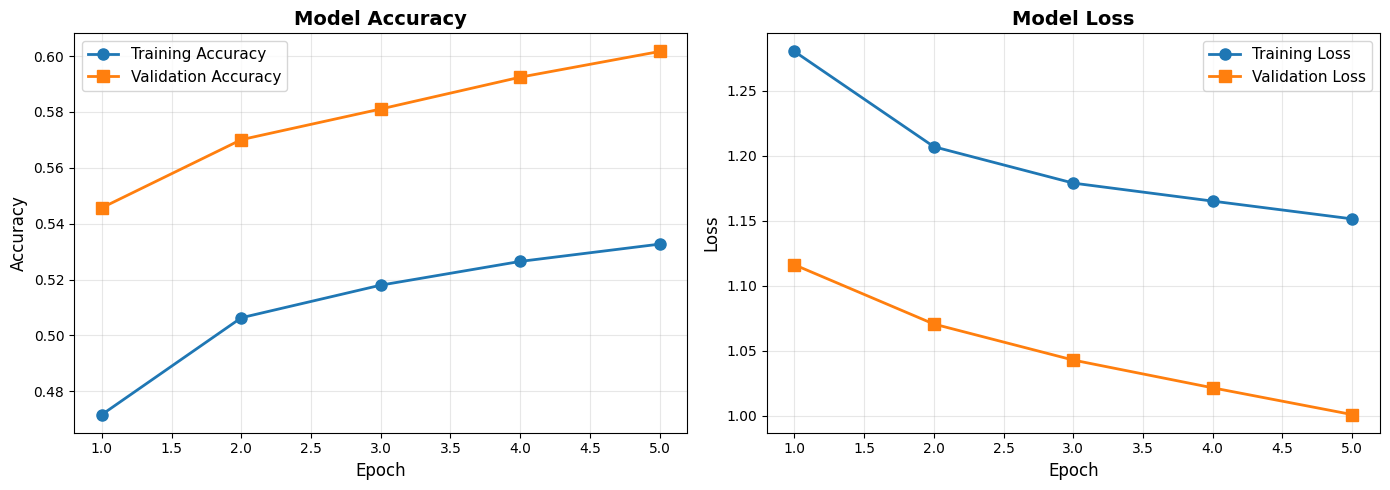

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

epochs_run = len(warm_up_history.history['accuracy'])
ax1.plot(range(1, epochs_run + 1), warm_up_history.history['accuracy'], 
         'o-', linewidth=2, markersize=8, label='Training Accuracy')
ax1.plot(range(1, epochs_run + 1), warm_up_history.history['val_accuracy'], 
         's-', linewidth=2, markersize=8, label='Validation Accuracy')
ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Loss grafiği
ax2.plot(range(1, epochs_run + 1), warm_up_history.history['loss'], 
         'o-', linewidth=2, markersize=8, label='Training Loss')
ax2.plot(range(1, epochs_run + 1), warm_up_history.history['val_loss'], 
         's-', linewidth=2, markersize=8, label='Validation Loss')
ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()

# Fine-Tuning the Transfer Learning Model

In this step, we **unfreeze part of the pre-trained base model** to fine-tune it on our dataset.

**What this code does:**

- **Unfreeze the base model:**  
  ```python
  base_model.trainable = True

In [11]:
base_model.trainable = True
print(f" Base Model Layers Num: {len(base_model.layers)}")

#for layer in base_model.layers[:int(len(base_model.layers)*0.8)]:
#    layer.trainable = False

#for layer in base_model.layers[int(len(base_model.layers)*0.8):]:
#    layer.trainable = True

for layer in base_model.layers[:int(len(base_model.layers)*0.8)]:
    layer.trainable = False

 Base Model Layers Num: 238


# Compile the Fine-Tuned Model

In this step, we **compile the model before training**. Compilation specifies the optimizer, loss function, and evaluation metrics.

**What this code does:**

- **Optimizer:**  
  ```python
  optimizer=Adam(learning_rate=1e-5)

In [12]:
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

## Finetune Training Callbacks: EarlyStopping, ReduceLROnPlateau & Learning Rate Scheduler

To improve training efficiency, prevent overfitting, and achieve better convergence, we use three Keras callbacks:

### 1. EarlyStopping
- Monitors the validation loss (`val_loss`).  
- Stops training if the validation loss does not improve for **3 consecutive epochs** (`patience=3`).  
- Automatically restores the model weights from the epoch with the **best validation loss** (`restore_best_weights=True`).  
- Provides verbose output to track when training stops.

### 2. ReduceLROnPlateau
- Monitors the validation loss (`val_loss`).  
- Reduces the learning rate by a factor of 0.5 if the validation loss does not improve for **2 consecutive epochs** (`patience=2`).  
- Ensures the learning rate does not go below `min_lr=1e-5`.  
- Helps the model converge by **lowering the learning rate when progress plateaus**.  
- Provides verbose output to show when the learning rate is reduced.

### 3. Cosine Annealing Learning Rate Scheduler
- Dynamically adjusts the learning rate during training following a **cosine curve**.  
- Starts with a higher learning rate (`initial_lr=1e-4`) and gradually decays to a minimum (`alpha=1e-6`).  
- Smoothly reduces learning rate over the total number of training steps, helping **stable convergence**.  
- Particularly effective in fine-tuning pre-trained models.

**Benefits:**  
- Faster convergence  
- Prevents overfitting  
- Helps reach **better validation performance**  
- Combines plateau detection and smooth LR decay for optimal training  

In [13]:
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "best_model.keras",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

tensorboard_cb = keras.callbacks.TensorBoard(
    log_dir="./logs",
    histogram_freq=1,
    update_freq="batch"
)

#%load_ext tensorboard
#%tensorboard --logdir ./logs

callbacks_list = [early_stop, reduce_lr, checkpoint_cb, tensorboard_cb]

# Start Finetune Training

In [14]:
history_finetune = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=40,
    callbacks=callbacks_list
)

Epoch 1/40


E0000 00:00:1763620391.605155     119 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763620391.747027     119 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763620392.161554     119 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763620392.305322     119 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


923/924 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.3905 - loss: 1.9077

E0000 00:00:1763620686.297224     118 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763620686.436487     118 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


924/924 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.3905 - loss: 1.9074

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_5']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)



Epoch 1: val_accuracy improved from -inf to 0.55769, saving model to best_model.keras
924/924 ━━━━━━━━━━━━━━━━━━━━ 395s 393ms/step - accuracy: 0.3906 - loss: 1.9072 - val_accuracy: 0.5577 - val_loss: 1.1135 - learning_rate: 1.0000e-05
Epoch 2/40
923/924 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.4803 - loss: 1.3435
Epoch 2: val_accuracy improved from 0.55769 to 0.60074, saving model to best_model.keras
924/924 ━━━━━━━━━━━━━━━━━━━━ 342s 369ms/step - accuracy: 0.4803 - loss: 1.3434 - val_accuracy: 0.6007 - val_loss: 0.9969 - learning_rate: 1.0000e-05
Epoch 3/40
923/924 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.5268 - loss: 1.1760
Epoch 3: val_accuracy improved from 0.60074 to 0.62651, saving model to best_model.keras
924/924 ━━━━━━━━━━━━━━━━━━━━ 340s 367ms/step - accuracy: 0.5268 - loss: 1.1759 - val_accuracy: 0.6265 - val_loss: 0.9411 - learning_rate: 1.0000e-05
Epoch 4/40
923/924 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.5560 - loss: 1.1047
Epoch 4: val_accuracy im

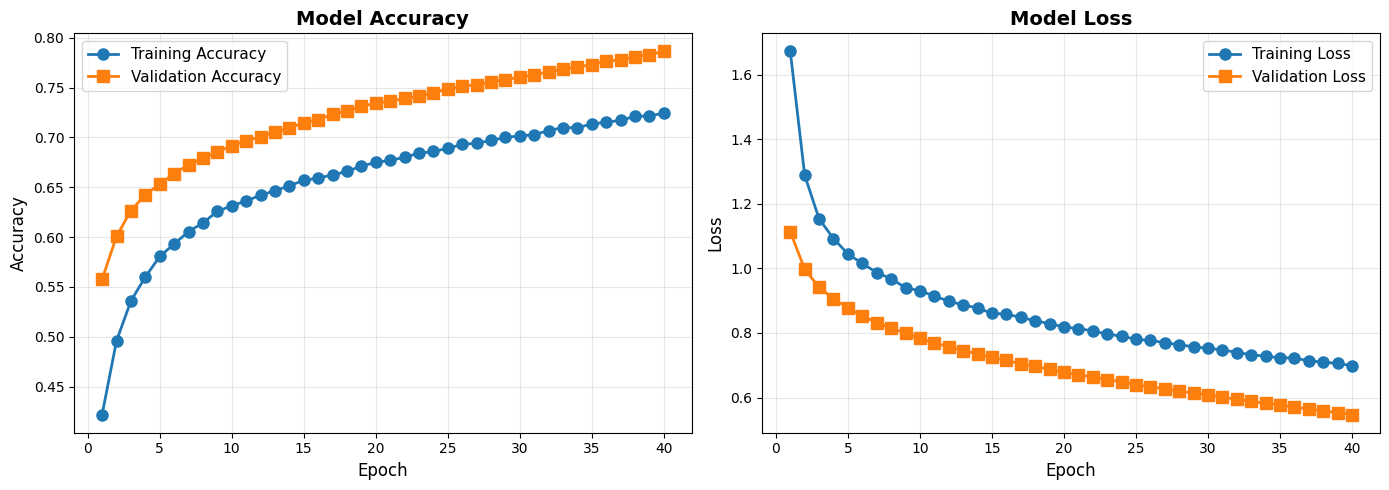

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

epochs_run = len(history_finetune.history['accuracy'])
ax1.plot(range(1, epochs_run + 1), history_finetune.history['accuracy'], 
         'o-', linewidth=2, markersize=8, label='Training Accuracy')
ax1.plot(range(1, epochs_run + 1), history_finetune.history['val_accuracy'], 
         's-', linewidth=2, markersize=8, label='Validation Accuracy')
ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Loss grafiği
ax2.plot(range(1, epochs_run + 1), history_finetune.history['loss'], 
         'o-', linewidth=2, markersize=8, label='Training Loss')
ax2.plot(range(1, epochs_run + 1), history_finetune.history['val_loss'], 
         's-', linewidth=2, markersize=8, label='Validation Loss')
ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()

## Extended Training for %80+ [Optional]

In [20]:
print("--- Final Step: Epoch 41-60 Start ---")

history_extended = model.fit(
    train_generator, 
    validation_data=validation_generator, 
    epochs=60,           
    initial_epoch=40,    
    callbacks=callbacks_list
)

--- Final Step: Epoch 41-60 Start ---
Epoch 41/60
923/924 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.7246 - loss: 0.6961
Epoch 41: val_accuracy improved from 0.78612 to 0.78881, saving model to best_model.keras
924/924 ━━━━━━━━━━━━━━━━━━━━ 351s 379ms/step - accuracy: 0.7246 - loss: 0.6961 - val_accuracy: 0.7888 - val_loss: 0.5410 - learning_rate: 1.0000e-05
Epoch 42/60
923/924 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.7237 - loss: 0.6970
Epoch 42: val_accuracy improved from 0.78881 to 0.79125, saving model to best_model.keras
924/924 ━━━━━━━━━━━━━━━━━━━━ 350s 378ms/step - accuracy: 0.7237 - loss: 0.6970 - val_accuracy: 0.7912 - val_loss: 0.5363 - learning_rate: 1.0000e-05
Epoch 43/60
923/924 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.7296 - loss: 0.6871
Epoch 43: val_accuracy improved from 0.79125 to 0.79220, saving model to best_model.keras
924/924 ━━━━━━━━━━━━━━━━━━━━ 354s 382ms/step - accuracy: 0.7296 - loss: 0.6871 - val_accuracy: 0.7922 - val_loss: 0.5317 - lear

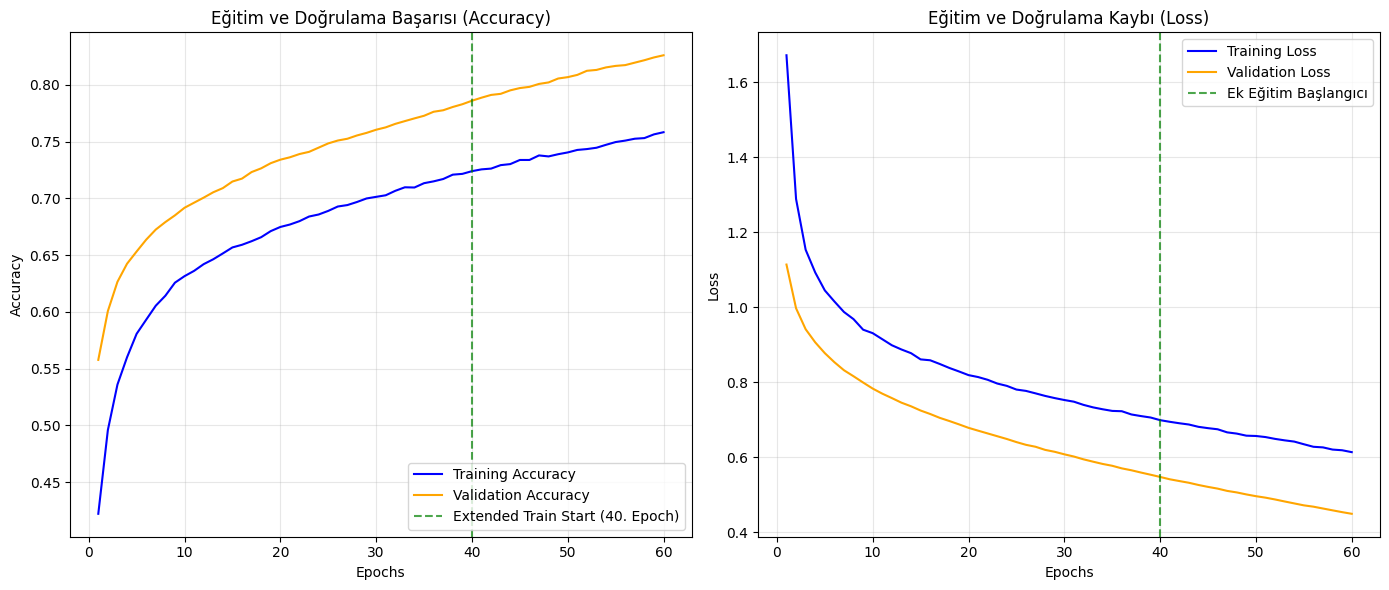

In [23]:
# Merge History 
acc_1 = history_finetune.history['accuracy']
val_acc_1 = history_finetune.history['val_accuracy']
loss_1 = history_finetune.history['loss']
val_loss_1 = history_finetune.history['val_loss']

acc_2 = history_extended.history['accuracy']
val_acc_2 = history_extended.history['val_accuracy']
loss_2 = history_extended.history['loss']
val_loss_2 = history_extended.history['val_loss']

acc = acc_1 + acc_2
val_acc = val_acc_1 + val_acc_2
loss = loss_1 + loss_2
val_loss = val_loss_1 + val_loss_2

split_point = len(acc_1) 

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color='blue')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='orange')

plt.axvline(x=split_point, color='green', linestyle='--', alpha=0.7, label=f'Extended Train Start ({split_point}. Epoch)')

plt.legend(loc='lower right')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color='blue')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange')

plt.axvline(x=split_point, color='green', linestyle='--', alpha=0.7, label=f'Extended Train Start')

plt.legend(loc='upper right')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## This is no longer an educational process, it's officially a show of force! 🤯

In [27]:
print("--- Record Attempt Continues: Epoch 61-80 ---")

model.save("backup_epoch_60_legendary.keras")

history_extended2 = model.fit(
    train_generator, 
    validation_data=validation_generator, 
    epochs=80,           
    initial_epoch=60,    
    callbacks=callbacks_list
)

--- Record Attempt Continues: Epoch 61-80 ---
Epoch 61/80
923/924 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.7576 - loss: 0.6158
Epoch 61: val_accuracy improved from 0.82621 to 0.82790, saving model to best_model.keras
924/924 ━━━━━━━━━━━━━━━━━━━━ 351s 379ms/step - accuracy: 0.7576 - loss: 0.6157 - val_accuracy: 0.8279 - val_loss: 0.4442 - learning_rate: 1.0000e-05
Epoch 62/80
923/924 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.7632 - loss: 0.6021
Epoch 62: val_accuracy improved from 0.82790 to 0.82949, saving model to best_model.keras
924/924 ━━━━━━━━━━━━━━━━━━━━ 345s 373ms/step - accuracy: 0.7632 - loss: 0.6021 - val_accuracy: 0.8295 - val_loss: 0.4398 - learning_rate: 1.0000e-05
Epoch 63/80
923/924 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.7601 - loss: 0.6093
Epoch 63: val_accuracy improved from 0.82949 to 0.83078, saving model to best_model.keras
924/924 ━━━━━━━━━━━━━━━━━━━━ 344s 371ms/step - accuracy: 0.7601 - loss: 0.6093 - val_accuracy: 0.8308 - val_loss: 0.436

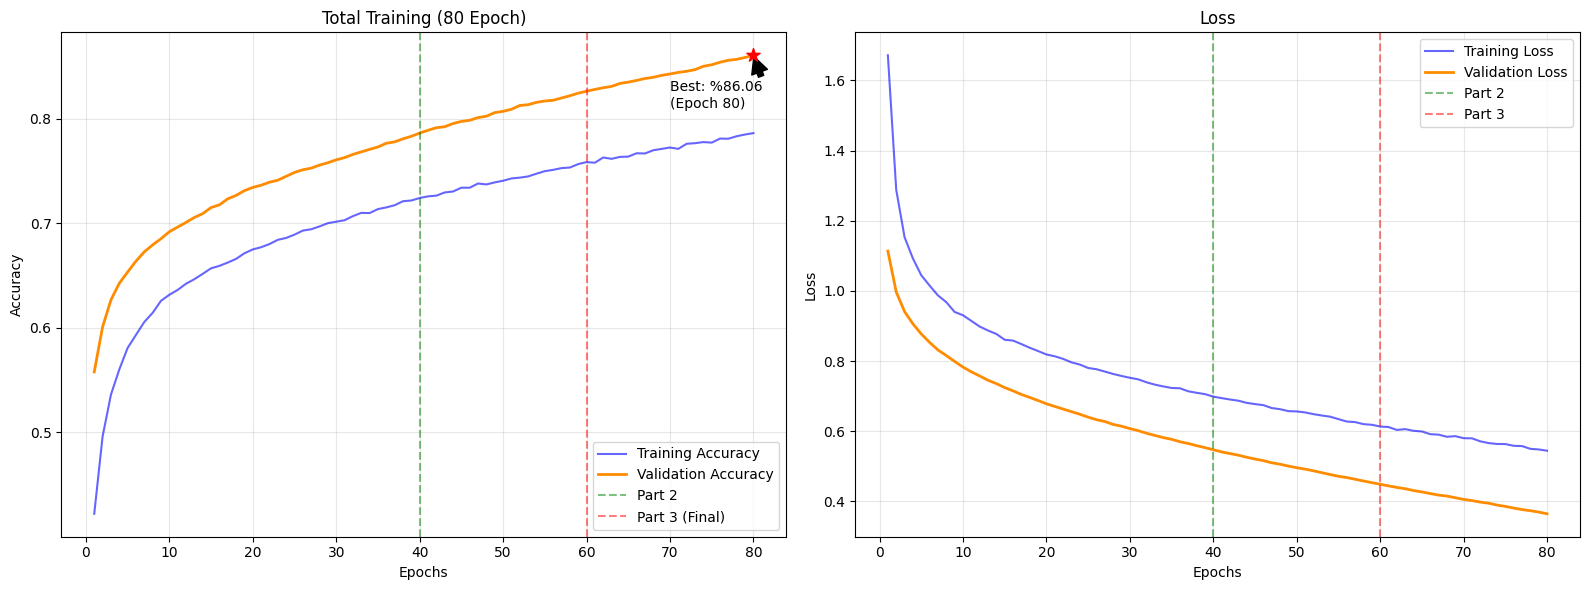

In [28]:

# 1. Step (First 40 Epoch)
h1 = history_finetune.history
# 2. Step (41-60 Epoch)
h2 = history_extended.history
# 3. Step (61-80 Epoch )
h3 = history_extended2.history  

acc = h1['accuracy'] + h2['accuracy'] + h3['accuracy']
val_acc = h1['val_accuracy'] + h2['val_accuracy'] + h3['val_accuracy']
loss = h1['loss'] + h2['loss'] + h3['loss']
val_loss = h1['val_loss'] + h2['val_loss'] + h3['val_loss']

epochs_range = range(1, len(acc) + 1)

stage_1_end = len(h1['accuracy']) 
stage_2_end = len(h1['accuracy']) + len(h2['accuracy']) 

best_val_acc = max(val_acc)
best_epoch = val_acc.index(best_val_acc) + 1


plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color='blue', alpha=0.6)
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='darkorange', linewidth=2)

plt.axvline(x=stage_1_end, color='green', linestyle='--', alpha=0.5, label='Part 2')
plt.axvline(x=stage_2_end, color='red', linestyle='--', alpha=0.5, label='Part 3 (Final)')

plt.scatter(best_epoch, best_val_acc, s=100, c='red', marker='*', zorder=5)
plt.annotate(f'Best: %{best_val_acc*100:.2f}\n(Epoch {best_epoch})', 
             (best_epoch, best_val_acc), 
             xytext=(best_epoch-10, best_val_acc-0.05),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.legend(loc='lower right')
plt.title(f'Total Training ({len(acc)} Epoch)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color='blue', alpha=0.6)
plt.plot(epochs_range, val_loss, label='Validation Loss', color='darkorange', linewidth=2)

plt.axvline(x=stage_1_end, color='green', linestyle='--', alpha=0.5, label='Part 2')
plt.axvline(x=stage_2_end, color='red', linestyle='--', alpha=0.5, label='Part 3')

plt.legend(loc='upper right')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Evaluate Model on Validation Set

In [29]:
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

924/924 ━━━━━━━━━━━━━━━━━━━━ 60s 65ms/step - accuracy: 0.8615 - loss: 0.3646
Validation Loss: 0.3646
Validation Accuracy: 0.8606


#  Confusion Matrix & Classification Report
- Inspect which classes are being confused and the precision/recall/F1-score.

Found 59099 files belonging to 5 classes.
Classes: ['Angry', 'Fear', 'Happy', 'Sad', 'Suprise']
Predict Start...
924/924 ━━━━━━━━━━━━━━━━━━━━ 78s 85ms/step
Get True labes...

--- Classification Report ---
              precision    recall  f1-score   support

       Angry       0.84      0.78      0.81     10148
        Fear       0.81      0.64      0.72      9732
       Happy       0.96      0.98      0.97     18439
         Sad       0.75      0.88      0.81     12553
     Suprise       0.90      0.93      0.91      8227

    accuracy                           0.86     59099
   macro avg       0.85      0.84      0.84     59099
weighted avg       0.86      0.86      0.86     59099



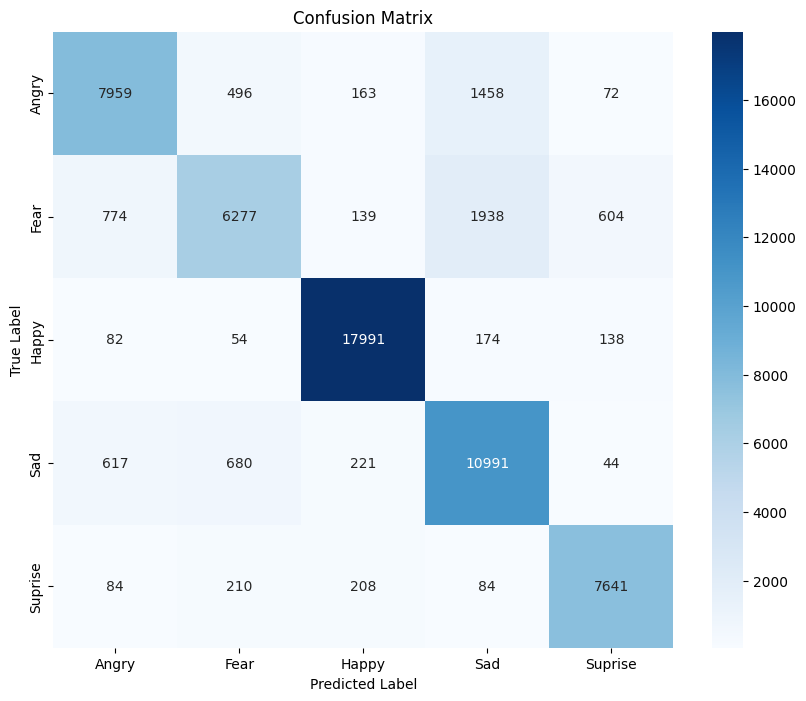

In [32]:
val_ds_eval = tf.keras.utils.image_dataset_from_directory(
    directory=data_dir, 
    labels='inferred',
    label_mode='categorical',
    batch_size=64,
    image_size=(224, 224),
    shuffle=False  
)

class_names = val_ds_eval.class_names
print(f"Classes: {class_names}")

print("Predict Start...")
y_pred_probs = model.predict(val_ds_eval) 
y_pred_classes = np.argmax(y_pred_probs, axis=1) 

print("Get True labes...")
y_true = np.concatenate([y for x, y in val_ds_eval], axis=0)
y_true_classes = np.argmax(y_true, axis=1)

print("\n--- Classification Report ---")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Save the Fine-Tuned Model

In [ ]:
#model.save("fine_tuned_emotion_model.h5")